In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

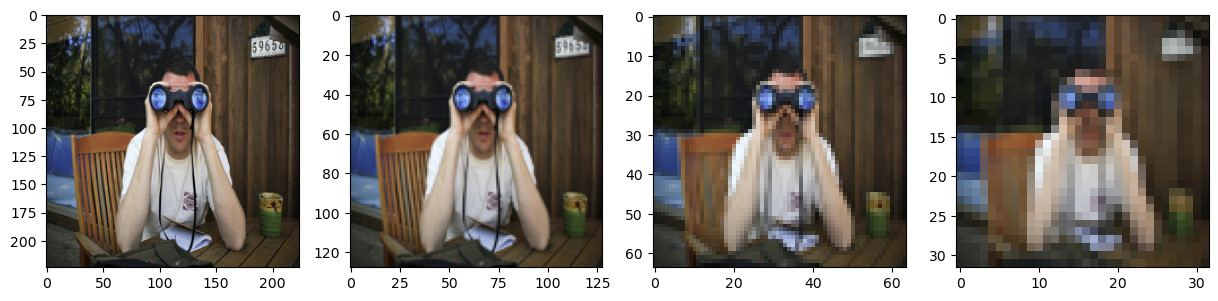

In [8]:
img = Image.open("/home/gc28692/Projects/continual_learning/continual_learning_playground/src/domain_shift/imagenet_corruption_demo/imgs/binoculars.JPEG")

fig,ax_array = plt.subplots(1,4,figsize=(15,4))
ax_array[0].imshow(img.resize((224,224)))
ax_array[1].imshow(img.resize((128,128)))
ax_array[2].imshow(img.resize((64,64)))
ax_array[3].imshow(img.resize((32,32)))

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np
import copy
from matplotlib.widgets import Slider, Button, RadioButtons
import cv2
from PIL import Image
from torchvision import transforms
import time
import torchvision.models as models


torch.backends.quantized.engine = 'qnnpack'

# load models
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT')
# mobilenet = models.quantization.mobilenet_v2(weights='DEFAULT',quantize=True)
mobilenet.eval()

Using cache found in /home/gc28692/.cache/torch/hub/pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [20]:
model = models.resnet34()
img = torch.rand((3,224,224))
img = img.unsqueeze(0)
start = time.time()
for i in range(100):
    model(img)
end = time.time()
avg = (end-start)/100
print("fps:",1/avg)

model = models.mobilenet_v2()
img = torch.rand((3,64,64))
img = img.unsqueeze(0)
start = time.time()
for i in range(100):
    model(img)
end = time.time()
avg2 = (end-start)/100
print("fps:",1/avg2)
print(avg/avg2)

fps: 43.14716519804801
fps: 188.22836719911896
4.36247355614534


In [32]:
import time

import torch
import numpy as np
from torchvision import models, transforms

import cv2
from PIL import Image

print(torch.__version__)
torch.backends.quantized.engine = 'qnnpack'

# cap = cv2.VideoCapture(-1)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 64)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 64)
# cap.set(cv2.CAP_PROP_FPS, 36)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

net = models.quantization.mobilenet_v2(weights='DEFAULT',quantize=True)
net.classifier[1] = torch.nn.Linear(1280,1000)
# net = models.mobilenet_v2()
# net = models.mobilenet_v2(pretrained=True)
# jit model to take it from ~20fps to ~30fps
net = torch.jit.script(net)

started = time.time()
last_logged = time.time()
frame_count = 0
torch.set_num_threads(2)
with torch.no_grad():
    while True:
        # read frame
        # ret, image = cap.read()
        # if not ret:
        #     raise RuntimeError("failed to read frame")

        # # convert opencv output from BGR to RGB
        # image = image[:, :, [2, 1, 0]]
        # permuted = image

        # preprocess
        # input_tensor = preprocess(image)
        input_tensor = torch.rand((3,64,64))

        # create a mini-batch as expected by the model
        input_batch = input_tensor.unsqueeze(0)

        # run model
        output = net(input_batch)
        # do something with output ...

        # log model performance
        frame_count += 1
        now = time.time()
        if now - last_logged > 1:
            print(f"{frame_count / (now-last_logged)} fps")
            last_logged = now
            frame_count = 0
        # cv2.imshow('img',image)

1.13.0


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torchvision/models/quantization/mobilenetv2.py", line 54, in forward
    def forward(self, x: Tensor) -> Tensor:
        x = self.quant(x)
        x = self._forward_impl(x)
            ~~~~~~~~~~~~~~~~~~ <--- HERE
        x = self.dequant(x)
        return x
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torchvision/models/mobilenetv2.py", line 170, in _forward_impl
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
            ~~~~~~~~~~~~~~~ <--- HERE
        return x
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/nn/modules/container.py", line 204, in forward
    def forward(self, input):
        for module in self:
            input = module(input)
                    ~~~~~~ <--- HERE
        return input
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/nn/modules/linear.py", line 114, in forward
    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)
               ~~~~~~~~ <--- HERE
RuntimeError: mat1 and mat2 must have the same dtype


In [11]:
mob = copy.deepcopy(mobilenet)

In [12]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

mob.fc = Identity()

In [31]:
net = models.quantization.mobilenet_v2(weights='DEFAULT',quantize=True)
net.classifier[1] = torch.nn.Linear(1280,1000)

/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/ao/quantization/utils.py:287: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
